# VoiceLoop VCTK-all Exploration
* This notebook gives basic exploration of the baseline VoiceLoop sim on the vctk-all dataset
* Checking that it generates reasonable voices for the full range of speakers
* Based on an earlier notebook so a bit of a mess...
* I'm using this notebook on 29-Jun-18 to help prepare the presentation for the meeting with Mark Herbster

## Run with original loop code, on the vctk-all dataset on aws-big

In [2]:
import os
os.chdir('/home/ubuntu/loop')

In [3]:
vctk_raw_folder = '/home/ubuntu/VCTK-Corpus/'
vctk_prebuilt_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/'

In [9]:
os.getcwd()

'/home/ubuntu/loop'

## 1) Setup <a id='setup'></a>

In [37]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
#from scipy.signal import butter, lfilter
#import scipy.ndimage
import os
import argparse

#import spectrograms.spectrogram_utils as su

#import winsound
import pandas as pd

import glob as gl
from IPython.display import display, HTML

import pydub as pyd
import spectrogram as sp
from utils import generate_merlin_wav

from data import *

import shutil as sh

import evaluate_loss_func_for_notebook as el

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

In [11]:
 def plot_spectrogram_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    #loop_dict['output_orig_fname']
    #loop_dict['output_fname']
    
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    data_a = sp.butter_bandpass_filter(data_a, lowcut, highcut, rate_a, order=1)
    
    rate_b, data_b = wavfile.read(mywav_b)
    data_b = sp.butter_bandpass_filter(data_b, lowcut, highcut, rate_b, order=1)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    # create spectrograms
    wav_spectrogram_a = sp.pretty_spectrogram(data_a.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)

    wav_spectrogram_b = sp.pretty_spectrogram(data_b.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)
    
    # create mel spectrograms if necessary
    if b_mel:        
         # Generate the mel filters
        mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq, samplerate=rate_a) # may need to change sample rate
    
        # create mel spectrograms
        mel_spec_a = sp.make_mel(wav_spectrogram_a, mel_filter, shorten_factor = shorten_factor)
        mel_spec_b = sp.make_mel(wav_spectrogram_b, mel_filter, shorten_factor = shorten_factor)
        
        # use mel spectrograms in the plots (hacky, needs tidying up)
        wav_spectrogram_a = np.float64(mel_spec_a)
        wav_spectrogram_b = np.float64(mel_spec_b)

   
    # plot spectrograms and the differences
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_a + '(' + label_a + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + wav_file_b + '(' + label_b + ')')

    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b - wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Difference: (' + wav_file_b + ' - ' + wav_file_a + ') (' + label_b + ' - ' + label_a + ')')

def plot_waveform_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    
    rate_b, data_b = wavfile.read(mywav_b)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    max_a = data_a.max()
    min_a = data_a.min()
    max_b = data_b.max()
    min_b = data_b.min()
    
    max_both = max([max_a, max_b])
    min_both = min([min_a, min_b])
    
    plt.figure(figsize=(15,6))
    
    ax = plt.subplot(3, 1, 1)
    plt.plot(data_a)
    plt.grid(True)
    plt.xlim(0, len(data_a))
    plt.ylim(min_both, max_both)
    plt.gca().set_xticks(range(0,len(data_a), rate_a), range(0, np.int(np.ceil(1.0*len(data_a)/rate_a))))
    plt.title(label_a)
    plt.ylabel('Amplitude')
    
    ax = plt.subplot(3, 1, 2)
    plt.plot(data_b)
    plt.grid(True)
    plt.xlim(0, len(data_b))
    plt.ylim(min_both, max_both)
    ax.set_xticks(range(0,len(data_b), rate_b), range(0, np.int(np.ceil(1.0*len(data_b)/rate_b))))
    plt.title(label_b)
    plt.ylabel('Amplitude')
    
    ax = plt.subplot(3, 1, 3)
    plt.plot(data_b - data_a)
    plt.grid(True)
    plt.xlim(0, len(data_b))
    plt.ylim(min_both, max_both)
    ax.set_xticks(range(0,len(data_b), rate_b), range(0, np.int(np.ceil(1.0*len(data_b)/rate_b))))
    plt.title('Diff: ' + label_b + ' - ' + label_a)
    plt.ylabel('Amplitude')


def plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot mgc features
    plt.figure(figsize=(20,20))
    for x in range(60):
        plt.subplot(10, 6, x+1)
        plt.plot(feats_a[:, x])
        plt.plot(feats_b[:, x])
        plt.title('mgc' + str(x))
        if x == 5:
            plt.legend([label_a, label_b])
        if x < 6*9:
            plt.gca().get_xaxis().set_visible(False)
        if not np.mod(x, 6) == 0:
            plt.gca().get_yaxis().set_visible(False)

    plt.suptitle('mgc features', fontsize=14)
    plt.show()

def plot_other_feature_comparison(feats_a, feats_b, label_a, label_b):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats_a[:, 60])
    plt.plot(feats_b[:, 60])
    plt.title('vuv')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 2)
    plt.plot(feats_a[:, 61])
    plt.plot(feats_b[:, 61])
    plt.title('lf0')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.subplot(1, 3, 3)
    plt.plot(feats_a[:, 62])
    plt.plot(feats_b[:, 62])
    plt.title('bap')
    plt.grid(True)
    plt.legend([label_a, label_b])

    plt.show()

In [33]:
def load_pre_calc_features(speaker_id, sample_id, b_valid=False, b_original=True):
    if b_original:
        pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    else:
        pre_calc_features_folder = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/numpy_features/'
        
    if b_valid:
        pre_calc_features_folder = pre_calc_features_folder.replace('_features', '_features_numpy')
        
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

In [13]:
def play_synthesized_features(feats, norm_path='/home/ubuntu/loop/data/vctk/norm_info/norm.dat'):
    output_dir = './'
    output_file = 'test.wav'

    generate_merlin_wav(feats['audio_features'],
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data

In [14]:
def display_vctk_sample(vctk_speaker_id, sample_id):
    # raw .wav file
    wav_file = os.path.join(vctk_raw_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

    # plot waveform
    plt.figure(figsize=(15,4))
    plt.plot(wav_data)
    plt.grid(True)
    plt.xlim(0, len(wav_data))
    plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

    # plot spectrogram
    plot_spectrogram(wav_data, rate)

In [15]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_raw_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

## Questions...
* Where are the norm files?

## 2) Speaker Info <a id = 'speaker_info'></a>

In [16]:
# load VCTK speaker_info metadata
speaker_info = get_vtck_speaker_info()
#speaker_info[speaker_info.id.isin(speaker_lookup.values())]
#tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
#pd.merge(speaker_info, tmp)

In [17]:
speaker_info.head()

,id,age,gender,accents,region
225,225,23,F,English,Southern England
226,226,22,M,English,Surrey
227,227,38,M,English,Cumbria
228,228,22,F,English,Southern England
229,229,23,F,English,Southern England


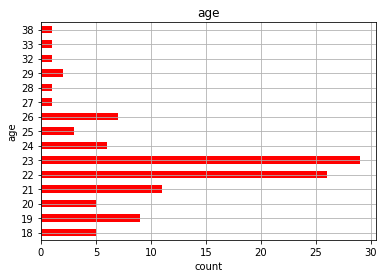

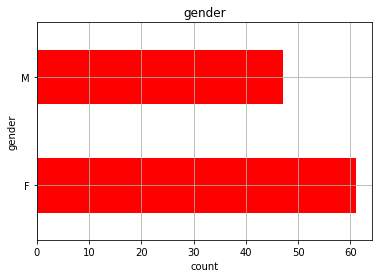

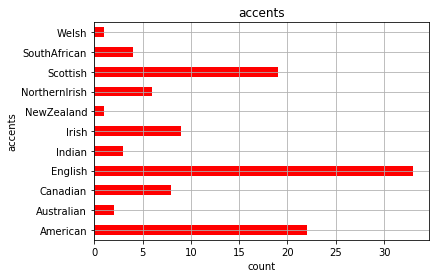

In [18]:
# plot descriptive statistics of speakers
for c in ['age', 'gender', 'accents']:
    plt.figure()
    speaker_info[c].value_counts().sort_index().plot(kind='barh', color='red', grid=True, title=c)
    plt.xlabel('count')
    plt.ylabel(c)

In [20]:
# there are lots of regions - too many to do much with them
#pd.DataFrame(speaker_info.groupby(['accents', 'region']).count()['id'])

## 3) Playing the Raw Files
* Start by identifying a speaker of interest
* Then find an interesting sample
* Then listen to the corresponding .wav file

#### Pick a speaker

In [22]:
# VoiceLoop only uses the speakers with American accents
speaker_info[speaker_info.accents == 'Indian']

,id,age,gender,accents,region
248,248,23,F,Indian,
251,251,26,M,Indian,
376,376,22,M,Indian,


In [23]:
# set speaker here
speaker_id = 248

#### Pick a sample

In [34]:
txt_folder = os.path.join(vctk_raw_folder, 'txt/p' + str(speaker_id))
txt_files = sorted(gl.glob(os.path.join(txt_folder, '*.txt')))

s = []
for t in txt_files:
    f = open(t, 'r')
    s.append(os.path.basename(t).replace('.txt', '') + ': ' + f.read())
    #s.append(f.read())
    #print f.read()
    f.close()
    
#pd.DataFrame(s, [os.path.basename(t).replace('.txt', '') for t in txt_files])
display(s)

['p248_001: Please call Stella.  \n',
 'p248_002: Ask her to bring these things with her from the store.  \n',
 'p248_003: Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  \n',
 'p248_004: We also need a small plastic snake and a big toy frog for the kids.  \n',
 'p248_005: She can scoop these things into three red bags, and we will go meet her Wednesday at the train station. \n',
 'p248_006: When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. \n',
 'p248_007: The rainbow is a division of white light into many beautiful colors. \n',
 'p248_008: These take the shape of a long round arch, with its path high above, and its two ends apparently beyond the horizon. \n',
 'p248_009: There is , according to legend, a boiling pot of gold at one end. \n',
 'p248_010: People look, but no one ever finds it. \n',
 'p248_011: When a man looks for something beyond his reach, his friends say he is looking for th

In [28]:
# set sample here
sample_id = 110

#### Play the audio file

,id,age,gender,accents,region
248,248,23,F,Indian,


It had been played at festivals.



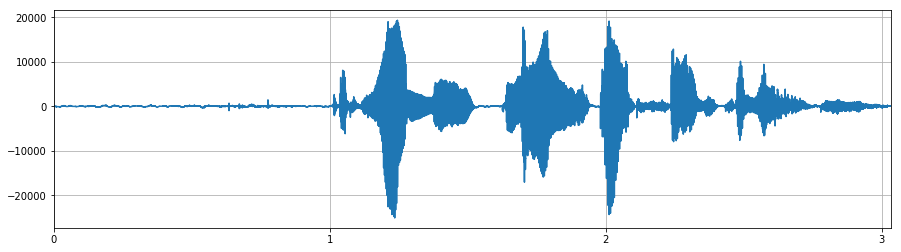

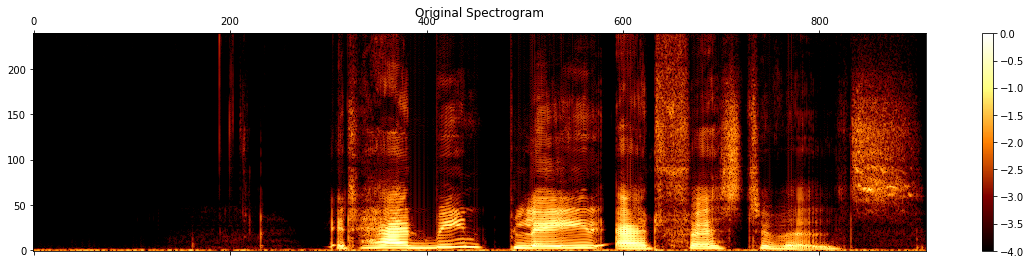

In [29]:
display_vctk_sample(speaker_id, sample_id)

## 4) Comparison of Original Samples to Synthesized Samples
* Load the pre-calculated WORLD features for the speaker-sample you listened to in part 3
* Note how the synthesized version compares to the original (some are very good, others less so)
* Plots below show how the waveforms and spectrograms compare. Typically they're similar, but with clear differences.
* The VCTK .wav files typically start with a long silence, which doesn't appear in the WORLD features. We should strip the silence out really to make the .wav files comparable.

#### Original pre-calculated features

In [44]:
# load pre-calculated WORLD features
feats = load_pre_calc_features(speaker_id, sample_id, b_original=False)

# synthesize sample from features and listen to the resulting .wav file
rate_synth, wav_data_synth = play_synthesized_features(feats, norm_path='/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-all/norm_info/norm.dat')

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.wav.


## 4) Investigate Pre-Computed .npz Files
* It's worth knowing what fields are in the .npz files
* You can see:
    * Original text
    * Phonemes generated from the text
    * Text features
    * WORLD audio features

In [186]:
# list of fields
feats.keys()

['code2phone', 'phonemes', 'language', 'audio_norminfo', 'audio_features']

#### Original text

In [187]:
feats['language']

array(1)

#### Phonemes

In [188]:
# the phoneme codes for this text transcript
feats['phonemes']

array([27, 11, 31, 12, 30,  1, 20,  9, 22,  4, 37, 12, 23, 13, 31,  1, 24,
        4, 28, 35, 12, 20,  5, 34, 38, 40, 16])

In [189]:
# code-to-phone lookup
print feats['code2phone']
print len(feats['code2phone'])

[u'pau' u'iy' u'aa' u'ch' u'ae' u'eh' u'ah' u'ao' u'ih' u'ey' u'aw' u'ay'
 u'ax' u'er' u'ng' u'sh' u'th' u'uh' u'zh' u'oy' u'dh' u'ow' u'hh' u'jh'
 u'b' u'd' u'g' u'f' u'k' u'm' u'l' u'n' u'p' u's' u'r' u't' u'w' u'v' u'y'
 u'z' u'uw']
41


In [190]:
# looked-up phonemes for this text transcript
# i.e. the phonetic version of the original text above
x = feats['phonemes']
#x[x==42] = 0 # for some reason, sometimes there is a phoneme with index=42, which doesn't appear in the dict.
" ".join(feats['code2phone'][x])

u'f ay n ax l iy dh ey hh ae v ax jh er n iy b ae k t ax dh eh r y uw th'

#### Feature Normalisation Info
mean and std for each of the 63 features prior to normalisation

In [191]:
feats['audio_norminfo'].shape

(2, 63)

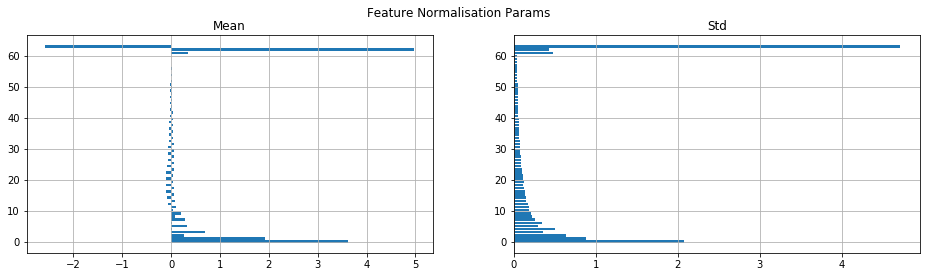

In [192]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.barh(np.linspace(0,63,63), feats['audio_norminfo'][0,:])
plt.grid(True)
plt.title('Mean')

plt.subplot(1,2,2)
plt.barh(np.linspace(0,63,63), feats['audio_norminfo'][1,:])
plt.grid(True)
plt.title('Std')

plt.suptitle('Feature Normalisation Params')
plt.show()

Note how different the normalisation scales are
The higher-order mcd are being normalised by very small variances, which blows up the normalised values. Presumably the network then can't really do much to train it away. How much does this matter? Is it effectively a fixed cost? Or is it negatively affecting the training of the network?

Could we floor the standard deviation?

TODO

* Run all the loss stuff on less-trained models. Do the losses start out similar? And then fall?

* Run glob on the npz files and look for anything in the VCTK set that hasn't been built

* Also compare to the pre-built VoiceLoop dataset - any differences?

* Compare some individual files to the pre-built VoiceLoop dataset? Look/sound similar?

* Quick run of npzloader on the new folders. Could modify to allow specification of which speakers to include?

* Could do quick and dirty copy of files for American speakers to a new folder

* Or could do a neat interface that creates a hashed list thing of train/test split cf. the Tensorflow tutorial? Do with a seed value etc. Base it on config files?

* get_config in python?

In [323]:
speaker_id = 294
sample_id = 5
pre_calc_features_folder_orig = '/home/ubuntu/loop/data/vctk/numpy_features/'
pre_calc_features_file_orig = os.path.join(pre_calc_features_folder_orig, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
feats_orig = np.load(pre_calc_features_file_orig)

pre_calc_features_folder_new = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/numpy_features/'
pre_calc_features_file_new = os.path.join(pre_calc_features_folder_new, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
feats_new = np.load(pre_calc_features_file_new)

In [324]:
print type(feats_orig['audio_norminfo'])
print type(feats_new['audio_norminfo'])

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [325]:
feats_new.keys()

['phonemes', 'code2phone', 'language', 'audio_features', 'audio_norminfo']

In [327]:
print feats_orig['audio_norminfo'].dtype
print feats_new['audio_norminfo'].dtype

float32
float32


In [228]:
type(feats_orig['audio_features'][0][0])

numpy.float32

In [229]:
type(feats['audio_features'][0][0])

numpy.float64

In [232]:
x = feats['audio_features']

In [233]:
type(x)

numpy.ndarray

In [235]:
x = x.astype(np.float32)

In [238]:
type(x[0][0])

numpy.float32

#### WORLD Acoustic Features

In [213]:
# (# time steps, 63 features)
feats['audio_features'].shape

(433, 63)

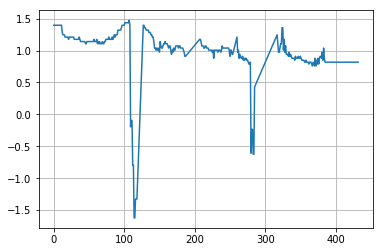

In [214]:
# Is this correct?
plt.plot(feats['audio_features'][:, 61])
plt.grid('True')

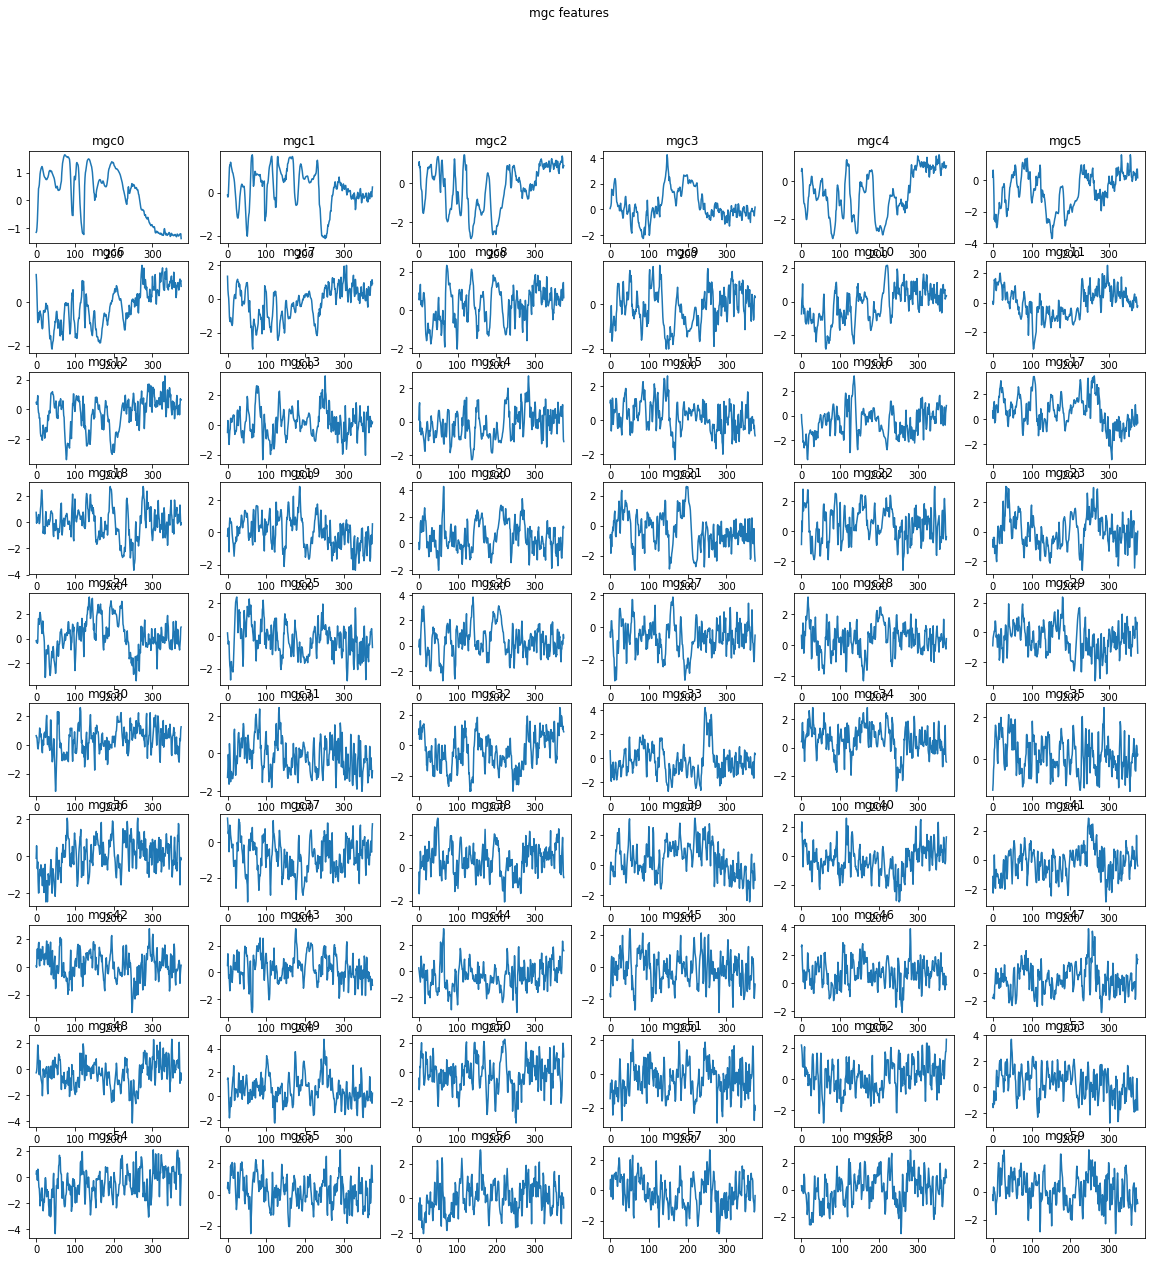

In [100]:
# plot mgc features
plt.figure(figsize=(20,20))
for x in range(60):
    plt.subplot(10, 6, x+1)
    plt.plot(feats['audio_features'][:, x])
    plt.title('mgc' + str(x))

plt.suptitle('mgc features')
plt.show()

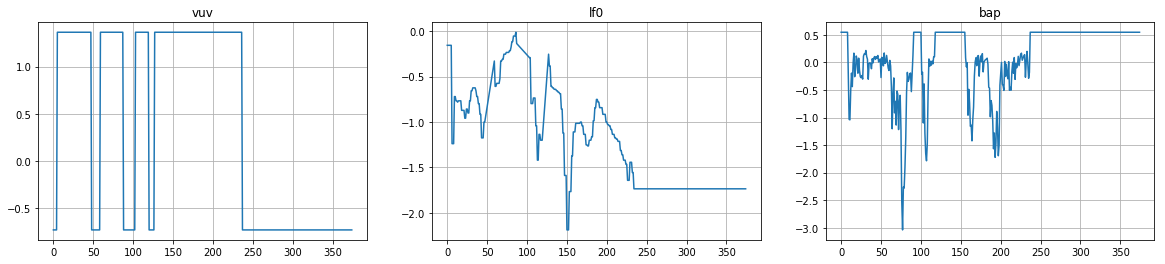

In [101]:
# plot lf0, vuv and bap features
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(feats['audio_features'][:, 60])
plt.title('vuv')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(feats['audio_features'][:, 61])
plt.title('lf0')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(feats['audio_features'][:, 62])
plt.title('bap')
plt.grid(True)

## 5) Check out the samples in the VCTK build
* Run glob on the folder to see what files are there
* Compare

In [41]:
# list of speakers with wav files in the VCTK dataset
speaker_folders = [int(g[len(os.path.join(vctk_raw_folder, 'wav48/p')):-1]) for g in gl.glob(os.path.join(vctk_raw_folder, 'wav48/*', ''))]

print len(speaker_folders)

109


In [103]:
# which speaker is missing from the .wav files?
idx_missing = set(speaker_folders) - set(speaker_info['id'])
print idx_missing

set([280])


In [43]:
# which speaker-samples are in the pre-calculated feature dataset that VoiceLoop uses?
pre_calc_features_folder = vctk_prebuilt_folder + '/numpy_features/'
feat_files = [os.path.basename(g)[:-4] for g in gl.glob(os.path.join(pre_calc_features_folder, '*.npz'))]

print len(feat_files)

44039


In [45]:
# find unique speakers in the pre-calculated dataset
feat_split = [f.split('_') for f in feat_files]
loop_speaker_ids = np.unique([int(f[0][1:]) for f in feat_split])
print len(loop_speaker_ids)
#speaker_info[speaker_info.index.isin(loop_speaker_ids)]

108


In [46]:
# which American speaker is missing?
idx_missing_american = set(speaker_info[speaker_info.accents == 'American']['id']) - set(loop_speaker_ids)

speaker_info[speaker_info.index.isin(idx_missing_american)]

# (it turns out they have no text transcripts)

,id,age,gender,accents,region
315,315,18,M,American,New England


In [50]:
for spkr in loop_speaker_ids:
    feat_split

In [60]:
pre_built_files = pd.DataFrame(feat_split, columns=('spkr', 'utterance'))

In [66]:
#pre_built_files.groupby('spkr').count()

In [74]:
# which speaker-samples are in the pre-calculated feature dataset that VoiceLoop uses?
vctk_prebuilt_folder_orig = '/home/ubuntu/loop/data/vctk'
pre_calc_features_folder_orig = vctk_prebuilt_folder_orig + '/numpy_features/'
feat_files = [os.path.basename(g)[:-4] for g in gl.glob(os.path.join(pre_calc_features_folder_orig, '*.npz'))]

print len(feat_files)

8015


In [124]:
for g in gl.glob(os.path.join(pre_calc_features_folder_orig, '*.npz')):
    if not os.path.isfile(os.path.join(vctk_prebuilt_folder, 'numpy_features', os.path.basename(g))):
        print "can't find: " + os.path.basename(g) + ' in ' + vctk_prebuilt_folder

can't find: p345_388.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p306_152.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p361_230.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p306_235.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p306_151.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p306_114.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p341_101.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p300_387.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p345_266.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p329_415.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p306_352.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p306_140.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p330_424.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/
can't find: p345_292.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/


In [125]:
for g in gl.glob(os.path.join(pre_calc_features_folder_orig.replace('_features', '_features_valid'), '*.npz')):
    if not os.path.isfile(os.path.join(vctk_prebuilt_folder, 'numpy_features', os.path.basename(g))):
        print "can't find: " + os.path.basename(g) + ' in ' + vctk_prebuilt_folder

can't find: p300_341.npz in /home/ubuntu/vctk-16khz-cmu-no-boundaries/


So almost all the training files in the VoiceLoop pre-built train and valid folders are present in Jiameng's folder.
Not sure why there's a handful missing, but not really a problem

In [127]:
for g in gl.glob(os.path.join(pre_calc_features_folder, '*.npz')):
    #print int(speaker_info[speaker_info.id == int(os.path.basename(g).split('_')[0][1:])]['accents'])
    try:
        if int(speaker_info[speaker_info.id == int(os.path.basename(g).split('_')[0][1:])]['accents'] == 'American') == 1:
            if not os.path.isfile(os.path.join(pre_calc_features_folder_orig,  os.path.basename(g))) and not os.path.isfile(os.path.join(pre_calc_features_folder_orig.replace('_features', '_features_valid'),  os.path.basename(g))):
                print "can't find: " + os.path.basename(g) + ' in ' + pre_calc_features_folder_orig
    except:
        print 'err: ' + os.path.basename(g)

err: p280_193.npz
err: p280_079.npz
err: p280_173.npz
err: p280_171.npz
err: p280_169.npz
err: p280_057.npz
err: p280_209.npz
err: p280_069.npz
err: p280_043.npz
err: p280_067.npz
err: p280_278.npz
err: p280_180.npz
err: p280_253.npz
err: p280_199.npz
err: p280_009.npz
err: p280_233.npz
err: p280_148.npz
err: p280_182.npz
err: p280_051.npz
err: p280_195.npz
err: p280_235.npz
err: p280_094.npz
err: p280_396.npz
err: p280_207.npz
err: p280_125.npz
err: p280_096.npz
err: p280_062.npz
err: p280_105.npz
err: p280_276.npz
err: p280_206.npz
err: p280_122.npz
err: p280_236.npz
err: p280_381.npz
err: p280_305.npz
err: p280_114.npz
err: p280_198.npz
err: p280_081.npz
err: p280_158.npz
err: p280_244.npz
err: p280_288.npz
err: p280_113.npz
err: p280_121.npz
err: p280_126.npz
err: p280_200.npz
err: p280_394.npz
err: p280_103.npz
err: p280_350.npz
err: p280_238.npz
err: p280_100.npz
err: p280_261.npz
err: p280_363.npz
err: p280_273.npz
err: p280_059.npz
err: p280_015.npz
err: p280_342.npz
err: p280_

so all the files for American speakers in Jiameng's folder are also in the VoiceLoop pre-built folder (either train or valid)

In [122]:
speaker_info[speaker_info.id == 280] # wav files, but no entry in speaker_info! Can we hack in some meta data?

,id,age,gender,accents,region


In [103]:
int(os.path.basename(g).split('_')[0][1:])

311

In [113]:
int(speaker_info[speaker_info.id == int(os.path.basename(g).split('_')[0][1:])]['accents'] == 'American') == 1

True

### Manually create the norm files

In [495]:
norm_info_file = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
#norm_info_file = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/norm_info/norm.dat'
fid = open(norm_info_file, 'rb')
cmp_info = np.fromfile(fid, dtype=np.float32)
fid.close()

cmp_info = cmp_info.reshape((2, -1))
cmp_mean = cmp_info[0, ]
cmp_std = cmp_info[1, ]

In [456]:
#np.array([cmp_mean, cmp_std]).transpose()
#cmp_info

In [457]:
#get_loader(data_path='data/vctk', 
max_seq_len=1000
batch_size=64,
nspk=22
data_path='../data/vctk-16khz-cmu-no-boundaries-us'
#data_path='../data/vctk'
dataset = NpzFolder(data_path + '/numpy_features', nspk == 1)
loader = NpzLoader(dataset,
                         max_seq_len=max_seq_len,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True)

In [458]:
tmp_feat = np.load(loader.dataset.npzs[0])
tmp_norm = tmp_feat['audio_norminfo']

In [459]:
for i in range(1,8000):
    tmp_feat = np.load(loader.dataset.npzs[0])
    test_norm = tmp_feat['audio_norminfo']
    #assert np.array_equal(tmp_norm, test_norm), "problem"
    assert np.array_equal(cmp_info, test_norm), "problem"
    

In [460]:
# write out norm info to file
norm_info_file = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/norm_info/norm.dat'
#tmp_norm.flatten().tofile(file=norm_info_file)

In [496]:
fid = open(norm_info_file, 'rb')
cmp_info_reload = np.fromfile(fid, dtype=np.float32)
fid.close()

cmp_info_reload = cmp_info_reload.reshape((2, -1))
cmp_mean_reload = cmp_info_reload[0, ]
cmp_std_reload = cmp_info_reload[1, ]

In [444]:
np.array_equal(cmp_info_reload, tmp_norm)

True

In [494]:
new = copy.deepcopy(cmp_info_reload)

In [498]:
old = copy.deepcopy(cmp_info_reload)

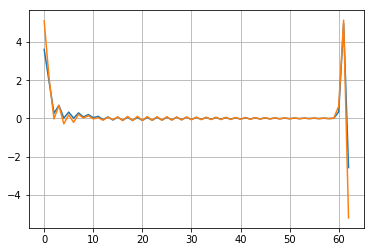

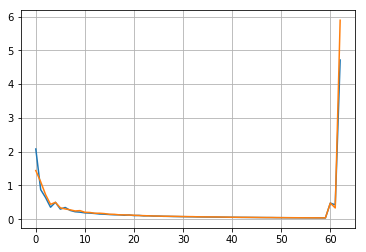

In [511]:
plt.plot(np.vstack([new[0,:], old[0,:]]).transpose())
plt.grid(True)
plt.show()

plt.plot(np.vstack([new[1,:], old[1,:]]).transpose())
plt.grid(True)
plt.show()

In [512]:
#np.vstack([new[0,:], old[0,:]]).transpose()

### Copy the American files across to a new folder

In [171]:
template_folder = '/home/ubuntu/loop/data/vctk'
folder_list = ('numpy_features', 'numpy_features_valid')
src_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features'
dest_folder = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us'

for f in folder_list:
    this_template = os.path.join(template_folder, f)
    this_dest = os.path.join(dest_folder, f)
    
    try:
        os.makedirs(this_dest)
    except:
        print "error"
    
    for g in gl.glob(os.path.join(this_template, '*.npz')):
        src_file = os.path.join(src_folder, os.path.basename(g))
        
        try:
            #print src_file
            sh.copy(src_file, this_dest)
        except:
            print "Couldn't copy: " + src_file
           

error
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p345_388.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_152.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p361_230.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_235.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_151.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_114.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p341_101.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p300_387.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p345_266.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p329_415.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_352.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/nu

In [176]:
os.listdir('/home/ubuntu/loop/data/vctk/norm_info')

['norm.dat']

In [184]:
sh.copytree('/home/ubuntu/loop/data/vctk/norm_info', '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/norm_info')

In [328]:
for f in folder_list:
    this_template = os.path.join(template_folder, f)
    this_dest = os.path.join(dest_folder, f)
    
    try:
        os.makedirs(this_dest)
    except:
        print "error"
    
    for g in gl.glob(os.path.join(this_template, '*.npz')):
        src_file = os.path.join(src_folder, os.path.basename(g))
        dest_file = os.path.join(this_dest, os.path.basename(g))
        
        try:
            tmp = dict(np.load(src_file))
            tmp['audio_features'] = tmp['audio_features'].astype(np.float32)
            tmp['audio_norminfo'] = tmp['audio_norminfo'].astype(np.float32)
            
            save_dict = {
                    'audio_features': tmp['audio_features'],
                    'code2phone': tmp['code2phone'],
                    'phonemes': tmp['phonemes'],
                    'language': tmp['language'],
                    'audio_norminfo': tmp['audio_norminfo'],
                }
            
            np.savez_compressed(dest_file, **tmp)
            #np.savez(dest_file, tmp)
        except:
            print "Couldn't copy: " + src_file
            

error
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p345_388.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_152.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p361_230.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_235.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_151.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_114.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p341_101.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p300_387.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p345_266.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p329_415.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features/p306_352.npz
Couldn't copy: /home/ubuntu/vctk-16khz-cmu-no-boundaries/nu

In [318]:
tmp['audio_norminfo'].dtype

dtype('float32')

In [255]:
x = tmp['audio_features'].astype(np.float32)

In [300]:
dest_file

'/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/numpy_features_valid/p311_349.npz'

In [316]:
save_dict = {
        'audio_features': tmp['audio_features'],
        'code2phone': tmp['code2phone'],
        'phonemes': tmp['phonemes'],
        'language': tmp['language'],
        'audio_norminfo': tmp['audio_norminfo'],
    }

KeyError: 'audio_features is not a file in the archive'

In [307]:
np.savez_compressed(dest_file, **tmp)

In [319]:
dest_file

'/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/numpy_features_valid/p311_349.npz'

In [320]:
tmp = np.load(dest_file)

In [322]:
tmp.keys()

['phonemes', 'code2phone', 'language', 'audio_features', 'audio_norminfo']

### Creating a Scottish Dataset!

In [695]:
scottish_speakers = speaker_info[speaker_info['accents'] == 'Scottish']

In [696]:
feat_files = [os.path.basename(g)[:-4] for g in gl.glob(os.path.join('/home/ubuntu/loop/data/vctk/numpy_features', '*.npz'))]

In [697]:
len(np.unique([f.split('_')[0] for f in feat_files]))

21

In [698]:
len(feat_files)

8015

In [699]:
feat_files = [os.path.basename(g)[:-4] for g in gl.glob(os.path.join('/home/ubuntu/loop/data/vctk/numpy_features_valid', '*.npz'))]

In [700]:
len(np.unique([f.split('_')[0] for f in feat_files]))

21

In [701]:
len(feat_files)

700

so the train/validation sets have the same set of speakers (i.e. no speakers are completely held-out)

Validation set is less than 10% of the size of the training set

In [702]:
feat_files = [os.path.basename(g)[:-4] for g in gl.glob(os.path.join('/home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features', '*.npz'))]

In [703]:
len(feat_files)

44039

In [704]:
all_spkr_id = [int(f.split('_')[0][1:]) for f in feat_files]

In [705]:
scottish_sprk_id = scottish_speakers['id'].values

In [706]:
num_scottish = len(scottish_speakers)

In [707]:
num_samples_for_speaker = np.zeros(num_scottish)
num_samples_for_speaker_valid = np.zeros(num_scottish, dtype=np.int8)
train_samples_for_speaker = []
valid_samples_for_speaker = []

for i, spkr in enumerate(scottish_sprk_id):
    idx_this_spkr = np.array([j == spkr for j in all_spkr_id])
    num_samples_for_speaker[i] = np.sum(idx_this_spkr)
    
    num_samples_for_speaker_valid[i] = np.int(np.floor(num_samples_for_speaker[i] * 0.1))
    
    flat_idx = np.flatnonzero(idx_this_spkr)
    np.random.shuffle(flat_idx)
    
    valid_samples_for_speaker.append(flat_idx[:num_samples_for_speaker_valid[i]])
    train_samples_for_speaker.append(flat_idx[num_samples_for_speaker_valid[i]:])    
    

In [709]:
src_folder = '/home/ubuntu/vctk-16khz-cmu-no-boundaries/numpy_features'
dest_folder = '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-sc'
feat_files_array = np.array(feat_files)

for i, spkr in enumerate(scottish_sprk_id):
    #f = 'numpy_features'
    f = 'numpy_features_valid'
    this_dest = os.path.join(dest_folder, f)
    
    try:
        os.makedirs(this_dest)
    except:
        pass
    
    #for t in feat_files_array[train_samples_for_speaker[i]]:
    for t in feat_files_array[valid_samples_for_speaker[i]]:
        this_src = os.path.join(src_folder, t+'.npz')
        this_dest_file = os.path.join(this_dest, t+'.npz')
        #print this_src, this_dest
        # also need to convert the floats... then copy
        
        try:
            tmp = dict(np.load(this_src))
            tmp['audio_features'] = tmp['audio_features'].astype(np.float32)
            tmp['audio_norminfo'] = tmp['audio_norminfo'].astype(np.float32)
            
            save_dict = {
                    'audio_features': tmp['audio_features'],
                    'code2phone': tmp['code2phone'],
                    'phonemes': tmp['phonemes'],
                    'language': tmp['language'],
                    'audio_norminfo': tmp['audio_norminfo'],
                }
            
            np.savez_compressed(this_dest_file, **tmp)
            #np.savez(dest_file, tmp)
        except:
            print "Couldn't copy: " + src_file

In [711]:
print len(os.listdir(os.path.join(dest_folder, 'numpy_features')))
print len(os.listdir(os.path.join(dest_folder, 'numpy_features_valid')))

6856
751


In [712]:
print 6856 + 751

7607


In [713]:
len(feat_files)

44039

In [715]:
np.sum([np.sum(scottish_sprk_id == s) for s in all_spkr_id])

7607

#### Copy norm_info file

In [716]:
sh.copytree('/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-us/norm_info', '/home/ubuntu/loop/data/vctk-16khz-cmu-no-boundaries-sc/norm_info')

## 6) Using PyDub to view frame rate etc.
Not especially useful

In [78]:
song = pyd.AudioSegment.from_wav(wav_file)

In [79]:
print "frame rate: " + str(song.frame_rate)
print "sample width: " + str(song.sample_width)
print "channels: " + str(song.channels)
print "duration (sec): " + str(song.duration_seconds)

frame rate: 48000
sample width: 2
channels: 1
duration (sec): 6.2728125


## TODO
* Phonemizer